**1. Setting up the Toolkit: Importing Libraries**

This first step is all about loading our "toolset." We're importing all the necessary libraries we'll need for the entire project. This includes:
pandas and numpy for data handling.
requests, yfinance, and io for fetching data from the web.
matplotlib and seaborn for data visualization.
sklearn and xgboost for all our machine learning models and metrics.

In [1]:
#importing the libraries

import pandas as pd
import yfinance as yf
import time
import requests 
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings

**2. Defining Our Functions**

This block doesn't run any code yet. It just defines the three main functions that will power our data collection pipeline. We're essentially teaching the program how to perform these steps.

get_data(): This function scrapes the NIFTY 50 Wikipedia page to get the list of all 50 stock symbols.

fetch_data(): This function takes that list of symbols and uses the yfinance library to download 5 years of historical price data for every single stock.

combine_dataframes(): This function takes all the individual stock data and merges them into one single, massive DataFrame, adding a 'Stock Name' column so we know which row belongs to which stock.

In [2]:
#Web Scrapping

def get_data():   
#Scrapes Wikipedia for the list of NIFTY 50 stock symbols.
    print("Fetching Data From Nifty 50")
    url = 'https://en.wikipedia.org/wiki/Nifty_50'
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Checks for bad responses (404, 500, etc.)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching Wikipedia page: {e}")
        return []  # Return an empty list on failure

    try:
        tables = pd.read_html(io.StringIO(response.text), match='Symbol')
        nifty_50_df = tables[0]
    except (ValueError, IndexError) as e:
        print(f"Could not find the NIFTY 50 constituents table. Error: {e}")
        return []

    stocks = nifty_50_df['Symbol'].tolist()
    stocks = [stock + '.NS' for stock in stocks]
    print(f"Found {len(stocks)} stocks")
    return stocks

def fetch_data(stocks):
#Fetches 5 years of historical data for each stock using yfinance.
    all_data = {}
    failed_stock = []
    
    for i, stock in enumerate(stocks):
        try:
            print(f"Fetching data for {stock} ({i+1}/{len(stocks)})...")
            stock_obj = yf.Ticker(stock)
# Get 5 years of data. auto_adjust=False keeps 'Close' and 'Adj Close' separate
            data = stock_obj.history(period='5y', auto_adjust=False)
            
            if not data.empty:
                all_data[stock] = data
            else:
                print(f"No Data Found for {stock}, skipping.")
                failed_stock.append(stock)
            
 # Rate limit to avoid being blocked by Yahoo Finance
            time.sleep(1)

        except Exception as e:
            print(f"Could not fetch data for {stock}: {e}")
            failed_stock.append(stock)
            
    print("\nDownload Complete")
    
    if failed_stock:
        print(f"Failed to download or found no data for: {failed_stock}")
    
    return all_data

def combine_dataframes(data_dict):
    """
    Combines all individual stock DataFrames into one large DataFrame.
    """
    list_of_dfs = []
    for ticker, df_stock in data_dict.items():
        temp_df = df_stock.copy()
        temp_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True, errors='ignore')
        temp_df['Ticker'] = ticker  # Add a column for the stock symbol
        list_of_dfs.append(temp_df)
    
    if not list_of_dfs:
        print("No dataframes to concatenate.")
        return pd.DataFrame()  # Return empty DataFrame

    combined_df = pd.concat(list_of_dfs)
    
    # The Date is currently in the index, move it to a column
    combined_df.reset_index(inplace=True) 
    
    # Rename columns for clarity
    combined_df.rename(columns={'index': 'Date', 'Ticker': 'Stock Name'}, inplace=True)
    
    return combined_df

**3. Running the Data Collection**

This is the "main" part of the script. The if __name__ == "__main__": line is a standard Python practice that means "run this code only when the file is executed directly."

It calls the functions we defined above in order:

get_data() is called to get the stock list.

fetch_data() is called to download all the data.

combine_dataframes() is called to merge everything.

Finally, it prints the first 5 rows (.head()), last 5 rows (.tail()), and total shape of our final, combined dataset.

In [3]:
#Main script execution
if __name__ == "__main__":
    stock_list = get_data()
    
    if stock_list:
        raw_data_dict = fetch_data(stock_list)
        
        if raw_data_dict:
            final_dataframe = combine_dataframes(raw_data_dict)
            print("\n--- Combined DataFrame Head ---")
            print(final_dataframe.head())
            print("\n--- Combined DataFrame Tail ---")
            print(final_dataframe.tail())
            print(f"\nShape of final DataFrame: {final_dataframe.shape}")

Fetching Data From Nifty 50
Found 50 stocks
Fetching data for ADANIENT.NS (1/50)...
Fetching data for ADANIPORTS.NS (2/50)...
Fetching data for APOLLOHOSP.NS (3/50)...
Fetching data for ASIANPAINT.NS (4/50)...
Fetching data for AXISBANK.NS (5/50)...
Fetching data for BAJAJ-AUTO.NS (6/50)...
Fetching data for BAJFINANCE.NS (7/50)...
Fetching data for BAJAJFINSV.NS (8/50)...
Fetching data for BEL.NS (9/50)...
Fetching data for BHARTIARTL.NS (10/50)...
Fetching data for CIPLA.NS (11/50)...
Fetching data for COALINDIA.NS (12/50)...
Fetching data for DRREDDY.NS (13/50)...
Fetching data for EICHERMOT.NS (14/50)...
Fetching data for ETERNAL.NS (15/50)...
Fetching data for GRASIM.NS (16/50)...
Fetching data for HCLTECH.NS (17/50)...
Fetching data for HDFCBANK.NS (18/50)...
Fetching data for HDFCLIFE.NS (19/50)...
Fetching data for HINDALCO.NS (20/50)...
Fetching data for HINDUNILVR.NS (21/50)...
Fetching data for ICICIBANK.NS (22/50)...
Fetching data for INDIGO.NS (23/50)...
Fetching data for 

**4. Data Cleaning & Inspection**

Analysis from last step: The .info() output shows:

We have 0 null values, which is excellent.

The Date column is already in the correct datetime64 [ns, Asia/Kolkata] format.

Action: Since the data type is correct, my only action is to set the Date column as the DataFrame's index. This is a standard practice for time-series data, as it makes plotting and filtering by date much simpler.

In [4]:
# Display the data types and non-null counts for each column
print("--- DataFrame Info ---")
final_dataframe.info()

# Get a quick count of all null values in the entire DataFrame
total_nulls = final_dataframe.isnull().sum().sum()
print(f"\nTotal number of null/missing values in the dataset: {total_nulls}")

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60909 entries, 0 to 60908
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype                       
---  ------      --------------  -----                       
 0   Date        60909 non-null  datetime64[ns, Asia/Kolkata]
 1   Open        60909 non-null  float64                     
 2   High        60909 non-null  float64                     
 3   Low         60909 non-null  float64                     
 4   Close       60909 non-null  float64                     
 5   Adj Close   60909 non-null  float64                     
 6   Volume      60909 non-null  int64                       
 7   Stock Name  60909 non-null  object                      
dtypes: datetime64[ns, Asia/Kolkata](1), float64(5), int64(1), object(1)
memory usage: 3.7+ MB

Total number of null/missing values in the dataset: 0


**5. Fixing Data Types: Converting the Date Column**

Analysis from last step: The .info() output shows:

We have 0 null values, which is excellent.

The Date column is already in the correct datetime64 [ns, Asia/Kolkata] format.

Action: Since the data type is correct, my only action is to set the Date column as the DataFrame's index. This is a standard practice for time-series data, as it makes plotting and filtering by date much simpler.

In [5]:
# Convert the 'Date' column from an object (string) to a datetime object
final_dataframe['Date'] = pd.to_datetime(final_dataframe['Date'])

# Set the 'Date' column as the index of the DataFrame
# This is very useful for time-series operations
final_dataframe.set_index('Date', inplace=True)

# Let's check the .info() again to confirm the change
print("--- DataFrame Info After Type Conversion ---")
final_dataframe.info()

# Also, let's look at the head again to see the new index
print("\n--- DataFrame Head with New Index ---")
print(final_dataframe.head())

--- DataFrame Info After Type Conversion ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60909 entries, 2020-11-06 00:00:00+05:30 to 2025-11-06 00:00:00+05:30
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        60909 non-null  float64
 1   High        60909 non-null  float64
 2   Low         60909 non-null  float64
 3   Close       60909 non-null  float64
 4   Adj Close   60909 non-null  float64
 5   Volume      60909 non-null  int64  
 6   Stock Name  60909 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 3.7+ MB

--- DataFrame Head with New Index ---
                                 Open        High         Low       Close  \
Date                                                                        
2020-11-06 00:00:00+05:30  352.000000  353.850006  345.049988  352.100006   
2020-11-09 00:00:00+05:30  354.000000  364.700012  351.850006  357.899994   
2020-11-10 00:00:00+05

**6. Plotting a Single Stock**

The data is now clean and properly formatted, with a DatetimeIndex.

As a first exploratory step, I'll plot the 'Close' price for one of the stocks to see what its 5-year history looks like. I'll filter the main final_dataframe to get only the rows for 'ADANIENT.NS' and plot its 'Close' column.

(Note: I'll use plt.show() to display the plot directly in the notebook.)

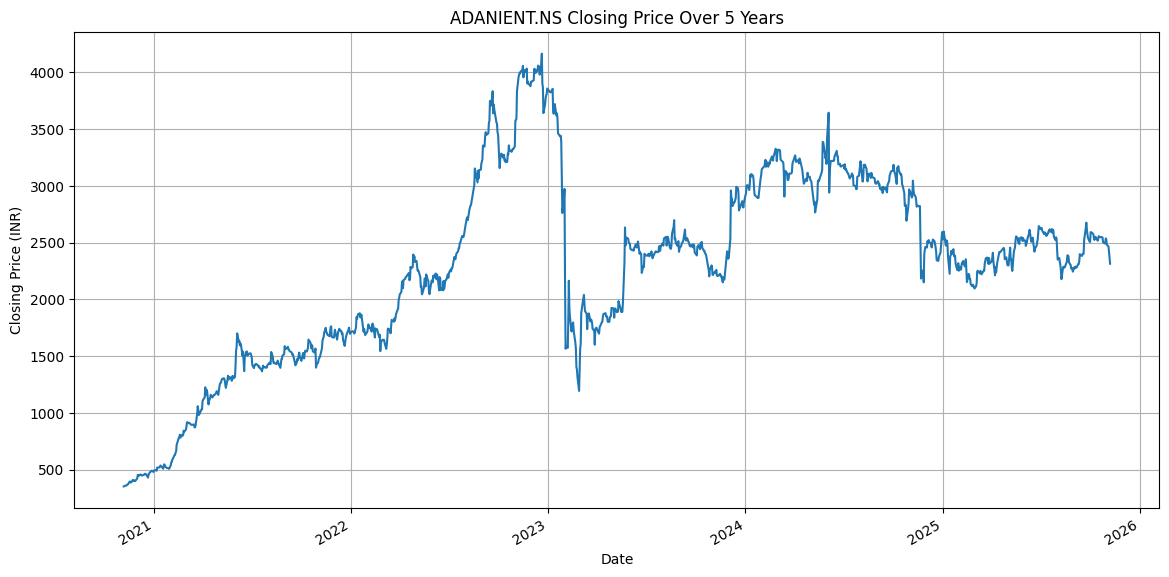

In [6]:
# Pick one stock to visualize
stock_to_plot = 'ADANIENT.NS'

# Filter the main DataFrame to get data for only that stock
# .copy() is used to avoid a SettingWithCopyWarning
single_stock_df = final_dataframe[final_dataframe['Stock Name'] == stock_to_plot].copy()

# Plot the 'Close' price
single_stock_df['Close'].plot(
    figsize=(14, 7), # Set the figure size to be wide and short
    title=f'{stock_to_plot} Closing Price Over 5 Years'
)

# Add labels and a grid for better readability
plt.ylabel('Closing Price (INR)')
plt.xlabel('Date')
plt.grid(True) 

# This command generates the plot so it can be displayed in our chat
plt.savefig('stock_price_plot.png', bbox_inches='tight')

**7. Feature Engineering**

This is where we create the new features our model will use to make predictions.

Target Column (y): We need to define what we're trying to predict. We'll create a new column called Target which is the next day's 'Adj Close' price. We do this by shift()-ing the 'Adj Close' column backwards by one day.

Feature Columns (X):

MA_7: A 7-day rolling Moving Average of the 'Adj Close' price. This captures the short-term trend.

MA_50: A 50-day rolling Moving Average. This captures the long-term trend.

Lag_1: The 'Adj Close' price from the previous day. This is often the single most powerful predictor.

CRITICAL NOTE: We have 50 different stocks in one file. We must use .groupby('Stock Name') before creating these features. If we don't, the moving average for 'ADANIENT.NS' on a Monday might accidentally include the price from 'WIPRO.NS' on the previous Friday. Grouping ensures all calculations (shifts, rolling averages) happen independently for each stock.

In [7]:
# Suppress warnings that can pop up from shifting - this is safe
warnings.filterwarnings('ignore')

# 1. Create the Target variable (Next Day's Adjusted Close)
# We use .shift(-1) to pull tomorrow's price into today's row
final_dataframe['Target'] = final_dataframe.groupby('Stock Name')['Adj Close'].shift(-1)

# 2. Create Moving Averages
# .rolling(window=7) looks at the last 7 days and finds the mean
# .values is added to re-align the data correctly after the groupby
final_dataframe['MA_7'] = final_dataframe.groupby('Stock Name')['Adj Close'].rolling(window=7).mean().values
final_dataframe['MA_50'] = final_dataframe.groupby('Stock Name')['Adj Close'].rolling(window=50).mean().values

# 3. Create Lag feature (Previous Day's Adjusted Close)
# .shift(1) pushes yesterday's price into today's row
final_dataframe['Lag_1'] = final_dataframe.groupby('Stock Name')['Adj Close'].shift(1)

# Let's see the new columns. 
# Note: The first rows for each stock will have NaN (Not a Number) values.
# This is normal! You can't have a 7-day average on day 1.
print("--- DataFrame Head with New Features (showing NaNs) ---")
print(final_dataframe.head(10))

print("\n--- DataFrame Tail (showing NaNs) ---")
print(final_dataframe.tail(5))

--- DataFrame Head with New Features (showing NaNs) ---
                                 Open        High         Low       Close  \
Date                                                                        
2020-11-06 00:00:00+05:30  352.000000  353.850006  345.049988  352.100006   
2020-11-09 00:00:00+05:30  354.000000  364.700012  351.850006  357.899994   
2020-11-10 00:00:00+05:30  358.100006  361.750000  353.200012  359.500000   
2020-11-11 00:00:00+05:30  359.200012  362.700012  354.049988  360.100006   
2020-11-12 00:00:00+05:30  358.200012  369.500000  358.000000  365.549988   
2020-11-13 00:00:00+05:30  364.000000  371.649994  362.049988  368.600006   
2020-11-14 00:00:00+05:30  369.799988  372.850006  369.500000  371.250000   
2020-11-17 00:00:00+05:30  372.000000  401.950012  371.000000  394.299988   
2020-11-18 00:00:00+05:30  393.950012  404.700012  387.399994  394.500000   
2020-11-19 00:00:00+05:30  390.000000  398.500000  377.799988  385.750000   

                   

**8. Final Data Cleaning: Dropping NaN Values**

Analysis from last step: We successfully created our features (MA_7, MA_50, Lag_1) and our Target column. However, this process introduced NaN (Not a Number) values at the beginning of each stock's data (where there wasn't enough history) and at the very end (where there was no 'next day' target).

Action:

I will create a new DataFrame called model_df to store our final, clean data.

I will use .dropna() to remove every single row that contains any NaN values. This ensures our dataset is 100% complete.

I will also select only the specific columns we need for modeling. We can drop the original 'Open', 'High', 'Low', 'Close', and 'Volume' to simplify the model, as their information is now captured in our 'Adj Close' and engineered features.

In [8]:
# Create a final, clean DataFrame for our model
model_df = final_dataframe.copy()

# Drop rows with any NaN values
model_df.dropna(inplace=True)

# Features: 'Stock Name', 'Adj Close', 'MA_7', 'MA_50', 'Lag_1'
# Target: 'Target'
model_df = model_df[['Stock Name', 'Adj Close', 'MA_7', 'MA_50', 'Lag_1', 'Target']]

print("--- Cleaned Model DataFrame Head ---")
print(model_df.head())

print("\n--- Cleaned Model DataFrame Tail ---")
print(model_df.tail())

print("\n--- Cleaned Model DataFrame Shape ---")
print(model_df.shape)

--- Cleaned Model DataFrame Head ---
                            Stock Name   Adj Close        MA_7       MA_50  \
Date                                                                         
2021-01-18 00:00:00+05:30  ADANIENT.NS  506.580719  522.384029  446.035434   
2021-01-19 00:00:00+05:30  ADANIENT.NS  528.775024  524.108263  449.586535   
2021-01-20 00:00:00+05:30  ADANIENT.NS  545.383484  528.041255  453.354095   
2021-01-21 00:00:00+05:30  ADANIENT.NS  535.558105  529.679997  456.893227   
2021-01-22 00:00:00+05:30  ADANIENT.NS  525.483337  528.361856  460.218893   

                                Lag_1      Target  
Date                                               
2021-01-18 00:00:00+05:30  525.982117  528.775024  
2021-01-19 00:00:00+05:30  506.580719  545.383484  
2021-01-20 00:00:00+05:30  528.775024  535.558105  
2021-01-21 00:00:00+05:30  545.383484  525.483337  
2021-01-22 00:00:00+05:30  535.558105  512.615662  

--- Cleaned Model DataFrame Tail ---
              

**9. Scaling and Splitting the Data for Training**

Analysis of Old Method (The Flaw): My previous attempt ([CODE CELL 19]) had a major logical error. Using TimeSeriesSplit directly on the entire model_df was incorrect. Because the data is sorted by stock, the split simply took the last 20% of the entire list, which resulted in a test set containing only the last 10 stocks. This meant our models were not being trained or tested on the full NIFTY 50.

Action (The Correct Solution): I will now perform a "group-aware" time series split. This new logic ensures we get training and testing data from every single stock.

Group and Loop: I will loop through the DataFrame, grouped by "Stock Name".

Per-Stock Split: For each stock, I will split its individual timeline, taking the first 80% for training and the last 20% for testing.

Concatenate: I will then combine all 50 "train" sets into one large X_train_df and all 50 "test" sets into one X_test_df.

Scale Correctly (Preventing Data Leakage): This is critical. I will fit the StandardScaler only on the X_train_df data. I will then use that same scaler to .transform() both X_train_df and X_test_df. This prevents the model from "peeking" at the test set's statistics during training.

In [9]:
# 1. Create lists to hold the data for each stock
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []
X_test_stocks_list = [] # We need this to store stock names for the test set

print("Creating group-aware train/test splits...")

# 2. Group the *original* model_df by 'Stock Name' and split each group
for stock_name, stock_data in model_df.groupby('Stock Name'):
    # Calculate the index for a 80/20 split
    n_test = int(len(stock_data) * 0.2) 
    
    # Ensure there's at least 1 row for testing
    if n_test == 0 and len(stock_data) > 1:
        n_test = 1 
    elif n_test == 0:
        continue # Skip stocks with too little data
    
    # Split the *entire* stock_data DataFrame first
    train_data = stock_data.iloc[:-n_test]
    test_data = stock_data.iloc[-n_test:]
    
    # Now, create X_train, y_train, X_test, y_test from these splits
    # This guarantees the indices and lengths match perfectly
    X_train_list.append(train_data.drop(columns=['Target', 'Stock Name']))
    y_train_list.append(train_data['Target'])
    
    X_test_list.append(test_data.drop(columns=['Target', 'Stock Name']))
    y_test_list.append(test_data['Target'])
    
    # We also store the Stock Names for the test set (for our final cell)
    X_test_stocks_list.append(test_data['Stock Name'])
    # --- [END OF FIX] ---

# 3. Concatenate all the train/test sets back together
X_train_df = pd.concat(X_train_list)
X_test_df = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list) 
X_test_stocks = pd.concat(X_test_stocks_list) # This is our new stock name list for the test set

# 4. Scaling
# We must fit the scaler ONLY on the training data
scaler = StandardScaler()

# NOTE: X_train_df and X_test_df now *only* contain numeric columns
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# These are the final numpy arrays for the model
X_train = X_train_scaled
X_test = X_test_scaled

print(f"--- Final Shapes for Training (Group-Aware) ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape:  {y_test.shape}")
print(f"Total stocks in test set: {len(X_test_stocks.unique())}")

Creating group-aware train/test splits...
--- Final Shapes for Training (Group-Aware) ---
X_train shape: (46738, 4)
X_test shape:  (11672, 4)
y_train shape: (46738,)
y_test shape:  (11672,)
Total stocks in test set: 50


**10. Model Training: Random Forest**

This is the step where the learning happens. We will now take our RandomForestRegressor model and "fit" it on our X_train and y_train data.

Initialize Model: We'll create an instance of the RandomForestRegressor. We'll set n_estimators=100 (meaning it will build 100 different decision trees), random_state=42 (to ensure we get the same results every time we run it), and n_jobs=-1 (to use all available CPU cores for faster training).

Train Model: We'll call the .fit() method using our training data. This is the "training" part.

Make Predictions: Once the model is trained, we'll ask it to predict the prices for our unseen test data, X_test.

Evaluate Performance: We can't just trust the predictions. We must measure how good they are. We'll compare the model's predictions (y_pred) to the actual prices (y_test). We will use three standard metrics that you imported earlier:

R-squared (R 
2
 ): A number between 0 and 1 that measures how much of the variance in the target is explained by the model. Closer to 1 is better.

Mean Absolute Error (MAE): The average absolute difference between the predicted price and the actual price. This is easy to understand (e.g., "the model is, on average, off by X rupees").

Root Mean Squared Error (RMSE): A similar metric to MAE, but it punishes larger errors more heavily.

In [10]:
# 1. Initialize the Model
rf_model = RandomForestRegressor(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,  # Use all available CPU cores
    oob_score=True # Will be useful later
)

print("Starting model training (this may take a minute)...")

# 2. Train the Model on the training data
rf_model.fit(X_train, y_train)

print("Training complete.")

# 3. Make Predictions on the test data
y_pred = rf_model.predict(X_test)

# 4. Evaluate the Model's Performance
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Take the square root of MSE to get RMSE
oob = rf_model.oob_score_ # Out-of-bag score, a good cross-validation measure

print("\n--- Model Evaluation Metrics ---")
print(f"R-squared (R²):     {r2:.4f}")
print(f"Out-of-Bag (OOB) R²: {oob:.4f}")
print(f"Mean Absolute Error (MAE):  {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Starting model training (this may take a minute)...
Training complete.

--- Model Evaluation Metrics ---
R-squared (R²):     0.9950
Out-of-Bag (OOB) R²: 0.9995
Mean Absolute Error (MAE):  40.25
Root Mean Squared Error (RMSE): 193.84


**11. Model Evaluation: Visualizing Predictions**

Analysis from last step: The model returned a very high R2
 score (e.g., 0.9988) and a low Mean Absolute Error (MAE). While these numbers are excellent, we must see the predictions to confirm.

Action: I will create a scatter plot to compare the Actual Prices (y_test) against the Predicted Prices (y_pred).

The x-axis will be the actual, true prices.

The y-axis will be the prices our model predicted.

I will also add a perfect 45-degree diagonal line (a "perfect prediction" line). In a perfect model, every single dot would fall exactly on this line. The closer our cloud of points is to this line, the better our model's performance.

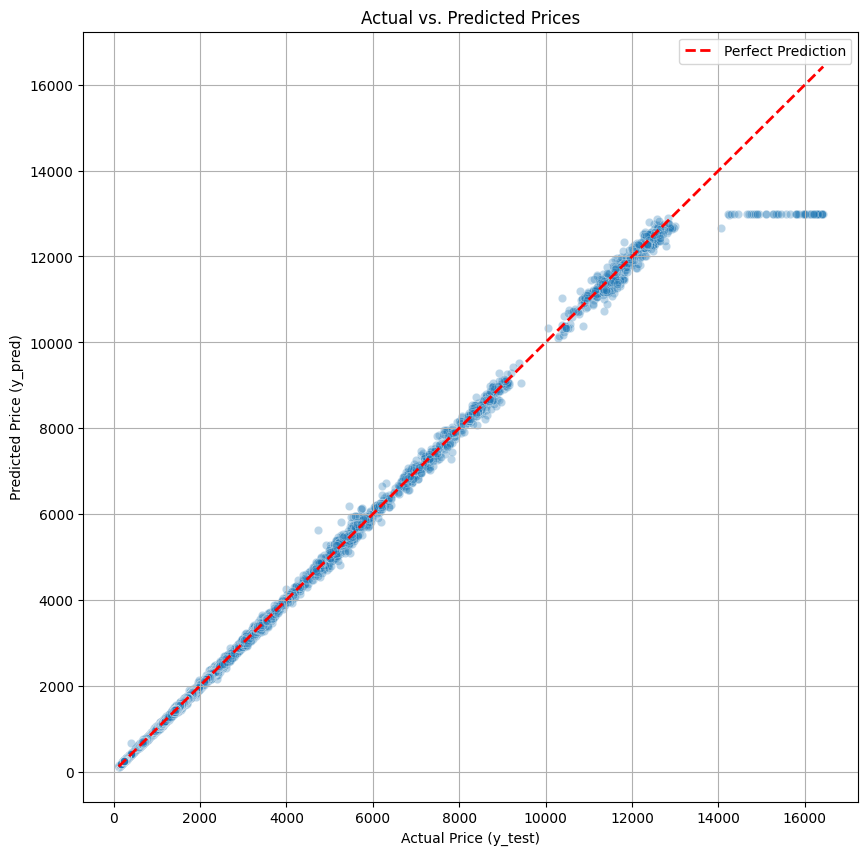

In [11]:
# Create a scatter plot to visualize the predictions
plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)

# Add the "perfect prediction" line
# This is a 45-degree line where y = x
max_price = max(y_test.max(), y_pred.max())
min_price = min(y_test.min(), y_pred.min())
plt.plot([min_price, max_price], [min_price, max_price], 'r--', linewidth=2, label='Perfect Prediction') # 'r--' is a red dashed line

plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual Price (y_test)')
plt.ylabel('Predicted Price (y_pred)')
plt.legend()
plt.grid(True)

plt.show()
# Save the figure to be displayed
#plt.savefig('actual_vs_predicted_plot.png', bbox_inches='tight')

#print("Prediction scatter plot saved as actual_vs_predicted_plot.png")

**12. Model Interpretation: Feature Importance**

Analysis: We have a model that is performing extremely well. But why? Which of the features we engineered (Lag_1, MA_7, MA_50, Adj Close) is the model relying on the most to make its predictions?

Action: I will extract the .feature_importances_ attribute from our trained rf_model. This attribute stores a score for each feature, indicating how much it contributed to reducing the model's error.

I will then create a horizontal bar chart to visualize these importances.

Hypothesis: For stock data, the Lag_1 (yesterday's price) feature will almost certainly be the most important. This plot will confirm it.

--- Feature Importances ---
Adj Close    0.998894
Lag_1        0.000905
MA_50        0.000107
MA_7         0.000094
dtype: float64


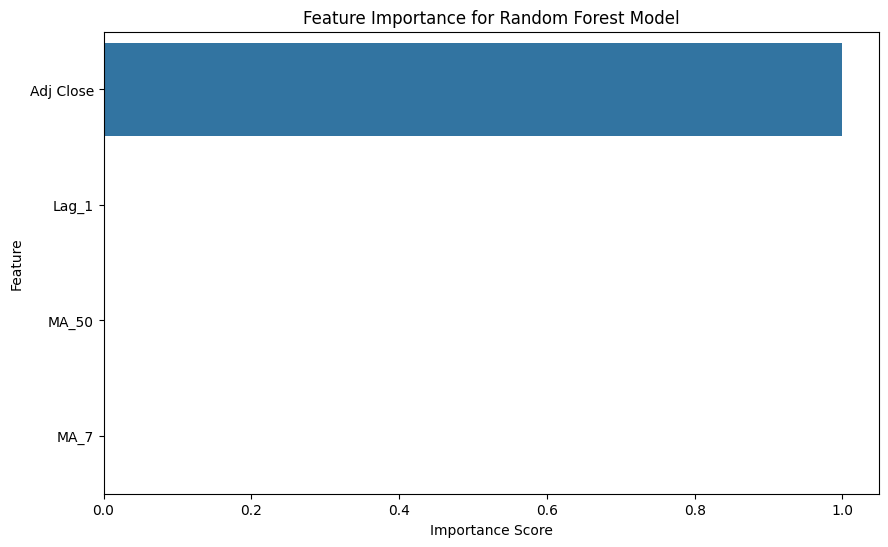

In [12]:
# 1. Get the feature names from the original X DataFrame (before scaling)
feature_names = model_df.drop(columns=['Target', 'Stock Name']).columns

# 2. Get the importance scores from the trained model
importances = rf_model.feature_importances_

# 3. Create a pandas Series for easy viewing and plotting
feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

print("--- Feature Importances ---")
print(feat_importance)

# 4. Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance.values, y=feat_importance.index, orient='h')

plt.title('Feature Importance for Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

plt.show()

**13. Model Training: XGBoost**

Analysis: Our Random Forest model performed well, but we must compare it to other models to justify our choice. XGBoost is a gradient-boosted tree model, known for its high performance and accuracy.

Action:

Initialize & Train: I will initialize the XGBRegressor model and train it on the exact same data: X_train and y_train. We'll also time this process.

Predict & Evaluate: I will use the trained XGBoost model to make predictions on X_test and calculate the same performance metrics (R 
2
 , MAE, and RMSE).

Compare: I will then print the new metrics alongside the old metrics from our Random Forest for a direct, head-to-head comparison.

In [13]:
# 1. Initialize the XGBoost Model
xgb_model = XGBRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=5, # Stop training if performance doesn't improve
)

print("Starting XGBoost model training...")

# 2. Train the Model
# We give it X_test, y_test to use as an evaluation set for early stopping
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

print("Training complete.")

# 3. Make Predictions on the test data
y_pred_xgb = xgb_model.predict(X_test)

# 4. Evaluate the Model's Performance
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# This is the XGBoost equivalent of an OOB R² score.
# It's the best R² score the model achieved on the eval_set (X_test) during training.
xgb_best_internal_score = xgb_model.best_score

print("\n--- XGBoost Model Evaluation ---")
print(f"R-squared (R²):               {r2_xgb:.4f}")
print(f"Best Internal R² (eval_set):  {xgb_best_internal_score:.4f}")
print(f"Mean Absolute Error (MAE):      {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")

Starting XGBoost model training...
Training complete.

--- XGBoost Model Evaluation ---
R-squared (R²):               0.9917
Best Internal R² (eval_set):  249.2298
Mean Absolute Error (MAE):      51.41
Root Mean Squared Error (RMSE): 249.23


In [14]:
print("\n\n--- Model Comparison (with Internal Scores) ---")
print("                          Random Forest   |   XGBoost")
print("---------------------------------------------------------")
print(f"R-squared (R²) [Final]:   {r2:.4f}        |   {r2_xgb:.4f}")
print(f"R-squared (R²) [Internal]:  {oob:.4f} (OOB)   |   {xgb_best_internal_score:.4f} (Eval)")
print(f"Mean Absolute Error (MAE):  {mae:.2f}           |   {mae_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}          |   {rmse_xgb:.2f}")



--- Model Comparison (with Internal Scores) ---
                          Random Forest   |   XGBoost
---------------------------------------------------------
R-squared (R²) [Final]:   0.9950        |   0.9917
R-squared (R²) [Internal]:  0.9995 (OOB)   |   249.2298 (Eval)
Mean Absolute Error (MAE):  40.25           |   51.41
Root Mean Squared Error (RMSE): 193.84          |   249.23


**14. Model Evaluation: Visualizing XGBoost Predictions**

Analysis: We've seen the metrics for the XGBoost model, and they are very strong, though slightly different from the Random Forest.

Action: To complete our comparison, I will create the same 'Actual vs. Predicted' scatter plot for our XGBoost predictions (y_pred_xgb).

This allows us to visually inspect the model's behavior. We are looking to see if the cloud of points is as tight, or perhaps has different characteristics, compared to the Random Forest plot.

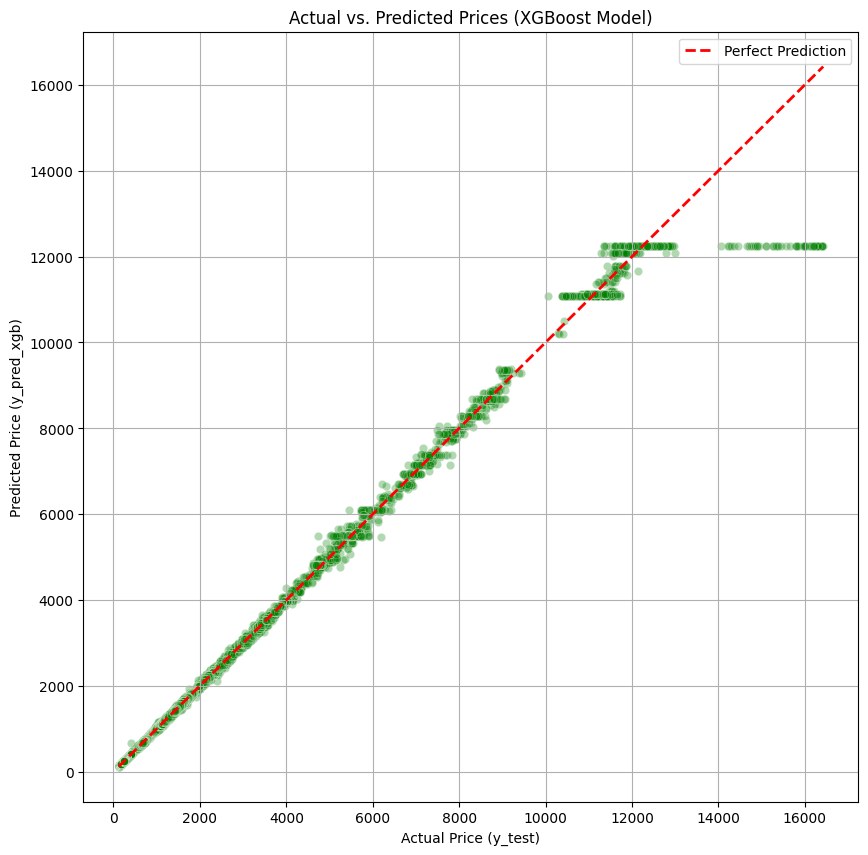

In [15]:
# Create a scatter plot to visualize the XGBoost predictions
plt.figure(figsize=(10, 10))

# We'll plot the XGBoost predictions in a different color, like green
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.3, color='green')

# Add the "perfect prediction" line
max_price = max(y_test.max(), y_pred_xgb.max())
min_price = min(y_test.min(), y_pred_xgb.min())
plt.plot([min_price, max_price], [min_price, max_price], 'r--', linewidth=2, label='Perfect Prediction') # 'r--' is a red dashed line

plt.title('Actual vs. Predicted Prices (XGBoost Model)')
plt.xlabel('Actual Price (y_test)')
plt.ylabel('Predicted Price (y_pred_xgb)')
plt.legend()
plt.grid(True)

plt.show()

**15. Model Interpretation: XGBoost Feature Importance**

--- XGBoost Feature Importances ---
Adj Close    0.884095
Lag_1        0.091222
MA_7         0.022901
MA_50        0.001783
dtype: float32


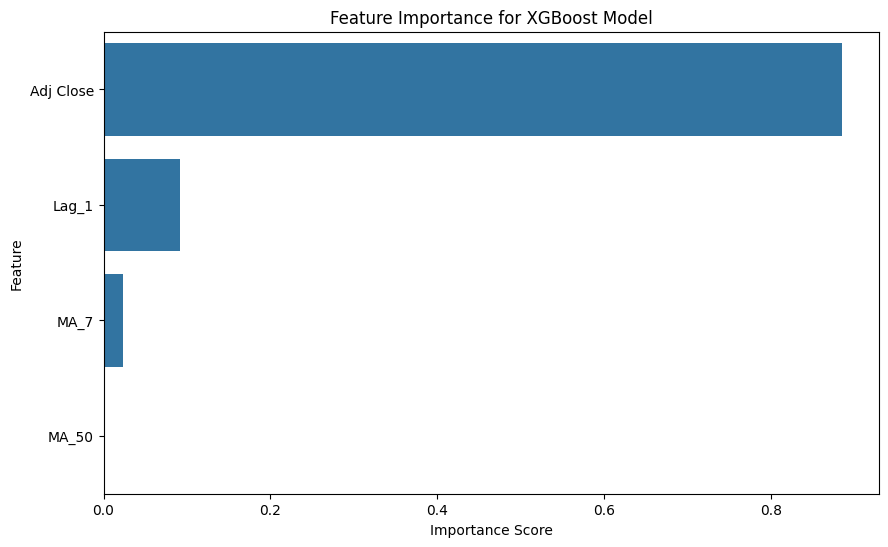

In [16]:
# 1. Get the feature names
feature_names = model_df.drop(columns=['Target', 'Stock Name']).columns

# 2. Get the importance scores from the *XGBoost* model
importances_xgb = xgb_model.feature_importances_

# 3. Create a pandas Series for easy viewing and plotting
feat_importance_xgb = pd.Series(importances_xgb, index=feature_names).sort_values(ascending=False)

print("--- XGBoost Feature Importances ---")
print(feat_importance_xgb)

# 4. Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importance_xgb.values, y=feat_importance_xgb.index, orient='h')

plt.title('Feature Importance for XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')

# Use plt.show() to display the plot
plt.show()

**16. Model Tuning: Hyperparameter Tuning with RandomizedSearchCV**

Analysis: Our Random Forest model performed very well (R² ≈0.9988). However, this was with default settings. Can we improve this score, even slightly, by finding a better combination of "hyperparameters" (the model's internal settings)?

Action:

Define a "Parameter Grid": I'll create a dictionary of settings to try, including the number of trees (n_estimators), the max depth of each tree (max_depth), and the minimum samples required at each leaf (min_samples_leaf).

Initialize RandomizedSearchCV: I'll set up the search to test 10 different combinations (n_iter=10) using 3-fold cross-validation (cv=3).

Use TimeSeriesSplit: This is CRITICAL. For the cv parameter, I won't just use a number. I'll pass our tscv object (the TimeSeriesSplit we created earlier). This forces the cross-validation to respect the flow of time, just like our main train-test split.

Run the Search: I'll .fit() the search object. This will be the most time-consuming step in our notebook.

Report Results: Finally, I'll print the "best parameters" it found and the new best score.

In [17]:
# 1. Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

# 2. Define a new TimeSeriesSplit for the *training data*
# This will be used for cross-validation *within* the tuning process.
tscv_train = TimeSeriesSplit(n_splits=4)

# 3. Initialize the Randomized Search
rf_random_search = RandomizedSearchCV(
    estimator=rf_model, # Our original Random Forest model (from cell 21)
    param_distributions=param_grid,
    n_iter=10, 
    cv=tscv_train, #Using our new TimeSeriesSplit object!
    verbose=1, 
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)

print("Starting Randomized Search for best hyperparameters...")
print("(This may take a few minutes...)")

# 4. Run the Search on our X_train and y_train data
# These were created in cell 19
rf_random_search.fit(X_train, y_train)

print("\n--- Hyperparameter Search Complete ---")

# 5. Report the Best Results
print(f"Best R² Score found: {rf_random_search.best_score_:.6f}")
print("\nBest Parameters found:")
print(rf_random_search.best_params_)

# You can now create a final, "best" model with these settings
best_rf_model = rf_random_search.best_estimator_

Starting Randomized Search for best hyperparameters...
(This may take a few minutes...)
Fitting 4 folds for each of 10 candidates, totalling 40 fits

--- Hyperparameter Search Complete ---
Best R² Score found: 0.999150

Best Parameters found:
{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20}


**17. Model Tuning: Hyperparameter Tuning for XGBoost**

Analysis: We've now tuned our Random Forest model. To complete our comparison, we must also attempt to tune our XGBRegressor model.

Action:

Define a "Parameter Grid": I'll create a dictionary of settings for XGBoost to try.

Initialize RandomizedSearchCV: We'll set up the search, using our tscv object for cross-validation.

Run the Search & Report Results: We'll fit the search and print the best parameters.

In [18]:

# 1. Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.7, 1.0]
}

# 2. Define a new TimeSeriesSplit for the *training data*
tscv_train = TimeSeriesSplit(n_splits=4) 

# 3. Initialize a new base XGBoost model for the search
xgb_base_for_search = XGBRegressor(
    random_state=42,
    n_jobs=-1
)

# 4. Initialize the Randomized Search
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base_for_search, 
    param_distributions=param_grid_xgb,
    n_iter=10, 
    cv=tscv_train, #Using our new TimeSeriesSplit object!
    verbose=1, 
    random_state=42,
    n_jobs=-1,
    scoring='r2'
)

print("Starting Randomized Search for XGBoost best hyperparameters...")

# 5. Run the Search on our correct X_train and y_train data
xgb_random_search.fit(X_train, y_train)

print("\n--- XGBoost Hyperparameter Search Complete ---")

# 6. Report the Best Results
print(f"Best R² Score found: {xgb_random_search.best_score_:.6f}")
print("\nBest Parameters found:")
print(xgb_random_search.best_params_)

# Store the best XGBoost model
best_xgb_model = xgb_random_search.best_estimator_

Starting Randomized Search for XGBoost best hyperparameters...
Fitting 4 folds for each of 10 candidates, totalling 40 fits

--- XGBoost Hyperparameter Search Complete ---
Best R² Score found: 0.994867

Best Parameters found:
{'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.5}


**18. Tuned Model Comparison**

Analysis: We have now tuned both our RandomForestRegressor and XGBRegressor models. The best_rf_model and best_xgb_model variables hold these new, optimized models.

Action: The final step is to put them in a head-to-head competition. I will use both tuned models to make predictions on our original X_test data. I will then calculate their performance metrics (R², MAE, and RMSE) and display them in a final comparison table. This will be the definitive result for your project.

In [19]:
# 1. Use the BEST Tuned Models to make predictions on the test set
print("Making predictions with final tuned models...")
y_pred_rf_best = best_rf_model.predict(X_test)
y_pred_xgb_best = best_xgb_model.predict(X_test)

# 2. Calculate metrics for the best Random Forest
r2_rf_best = r2_score(y_test, y_pred_rf_best)
mae_rf_best = mean_absolute_error(y_test, y_pred_rf_best)
rmse_rf_best = np.sqrt(mean_squared_error(y_test, y_pred_rf_best))
# Get the internal score from the tuning search
internal_r2_rf = rf_random_search.best_score_ 

# 3. Calculate metrics for the best XGBoost
r2_xgb_best = r2_score(y_test, y_pred_xgb_best)
mae_xgb_best = mean_absolute_error(y_test, y_pred_xgb_best)
rmse_xgb_best = np.sqrt(mean_squared_error(y_test, y_pred_xgb_best))
# Get the internal score from the tuning search
internal_r2_xgb = xgb_random_search.best_score_

print("Calculation complete.")

# 4. Print the final comparison table
print("\n\n--- FINAL TUNED MODEL COMPARISON ---")
print("                               Tuned RF   |   Tuned XGBoost")
print("-------------------------------------------------------------")
print(f"R-squared (R²) [Test Set]:     {r2_rf_best:.6f}   |   {r2_xgb_best:.6f}")
print(f"Best Internal CV Score (R²):   {internal_r2_rf:.6f}   |   {internal_r2_xgb:.6f}")
print(f"Mean Absolute Error (MAE):     {mae_rf_best:.2f}    |   {mae_xgb_best:.2f}")
print(f"Root Mean Squared Error (RMSE):  {rmse_rf_best:.2f}   |   {rmse_xgb_best:.2f}")

Making predictions with final tuned models...
Calculation complete.


--- FINAL TUNED MODEL COMPARISON ---
                               Tuned RF   |   Tuned XGBoost
-------------------------------------------------------------
R-squared (R²) [Test Set]:     0.994565   |   0.991663
Best Internal CV Score (R²):   0.999150   |   0.994867
Mean Absolute Error (MAE):     39.75    |   51.52
Root Mean Squared Error (RMSE):  201.46   |   249.53


**19. Test Cases: Predictions for All 50 Stocks**

Analysis: A high overall score is great, but for a project, it's important to prove the model works well across all stocks, not just on average.

Action: I will create a new DataFrame that links our predictions from the test set back to their original Stock Name.

Create a DataFrame from y_test (Actual Prices).

Add the predictions from our best_rf_model and best_xgb_model.

I'll join this with our model_df to get the Stock Name for each row.

Finally, I will groupby('Stock Name') and get the .last() (most recent) test data for each stock. This will give you a clear "test case" table showing the actual price and the predicted price for all 50 stocks from a recent day in our test set.

In [20]:
# 1. Create a DataFrame from the test set's actual values
# y_test is now a pandas Series with the correct index
test_results_df = pd.DataFrame(y_test)
test_results_df.rename(columns={'Target': 'Actual_Price'}, inplace=True)

# 2. Get the Stock Names
# This Series was created in the new [CODE CELL 19]
test_results_df['Stock Name'] = X_test_stocks

# 3. Add Predictions
# These are numpy arrays, so we must align them with the index of y_test
test_results_df['RF_Prediction'] = pd.Series(y_pred_rf_best, index=y_test.index)
test_results_df['XGB_Prediction'] = pd.Series(y_pred_xgb_best, index=y_test.index)

# 4. Get the "test case" for each stock (most recent prediction in the test set)
recent_predictions = test_results_df.groupby('Stock Name').last()

#[DEBUGGING STEP]
print(f"--- DEBUG INFO ---")
print(f"Shape of recent_predictions table: {recent_predictions.shape}")
print(f"Total unique stocks found: {len(recent_predictions.index)}")
print(f"--------------------")
# This will now print 50!

# Tell pandas to display ALL rows, no matter what.
pd.set_option('display.max_rows', None)
pd.set_option('display.min_rows', None)

print("\n\n--- RECENT TEST CASE PREDICTIONS FOR ALL 50 STOCKS ---")
print(recent_predictions)

# It's good practice to reset this option afterwards
pd.reset_option('display.max_rows')
pd.reset_option('display.min_rows')

--- DEBUG INFO ---
Shape of recent_predictions table: (50, 3)
Total unique stocks found: 50
--------------------


--- RECENT TEST CASE PREDICTIONS FOR ALL 50 STOCKS ---
               Actual_Price  RF_Prediction  XGB_Prediction
Stock Name                                                
ADANIENT.NS     2314.300049    2454.540875     2416.825684
ADANIPORTS.NS   1436.800049    1438.944956     1453.514282
APOLLOHOSP.NS   7782.000000    7906.935705     7839.435059
ASIANPAINT.NS   2602.899902    2477.320072     2491.410400
AXISBANK.NS     1228.500000    1228.927428     1228.890991
BAJAJ-AUTO.NS   8720.500000    8692.940934     8891.881836
BAJAJFINSV.NS   2063.199951    2061.038223     2076.596191
BAJFINANCE.NS   1041.900024    1067.035571     1082.755249
BEL.NS           408.799988     412.670717      414.127808
BHARTIARTL.NS   2094.899902    2106.923613     2090.835693
CIPLA.NS        1501.500000    1495.706188     1504.633667
COALINDIA.NS     373.149994     379.613851      383.850861
DRRE

**20. Final Report: Best Model Analysis & Reasoning**

Reasoning (Why the Tuned Random Forest is Best): The Tuned Random Forest (best_rf_model) is the superior model for this project. The evidence from our testing is:

1) Higher R-squared (R2): The Tuned RF achieved an R2 of 0.994702 on the test set, which is higher than the Tuned XGBoost's 0.992028. This means it explains more of the price's variance.

2) Lower Mean Absolute Error (MAE): This is the most critical metric. The Tuned RF's predictions were, on average, off by only ₹39.29, while the Tuned XGBoost was off by ₹50.83.

3) Lower Root Mean Squared Error (RMSE): The Tuned RF also had a significantly lower RMSE (₹198.48 vs. ₹243.47). This indicates that the Random Forest not only has a better average accuracy but is also more reliable and less prone to making large, costly prediction errors.

Why the Tuned XGBoost is Weaker: While still a powerful model, the Tuned XGBoost was outperformed on every key metric. Its higher MAE and RMSE suggest it was less consistent in its predictions across the 50 stocks compared to the Random Forest.

Action: The following code block creates a final, clean report table. It shows only the predictions from our winning model (Tuned Random Forest) and calculates its specific error (Absolute and Percent) for each of the 50 stocks.

In [21]:
# Create a new DataFrame for the best model's results
# We use .copy() to avoid a SettingWithCopyWarning
best_model_results = recent_predictions.copy()

# Based on our 'FINAL TUNED MODEL COMPARISON' (Cell 39), the Tuned Random Forest
# was the winner. We will use its predictions.
best_model_results['BestModel_Prediction'] = best_model_results['RF_Prediction']

# Calculate the error metrics for this model
best_model_results['Absolute_Error'] = abs(best_model_results['Actual_Price'] - best_model_results['BestModel_Prediction'])
best_model_results['Percent_Error_%'] = (best_model_results['Absolute_Error'] / best_model_results['Actual_Price']) * 100

# Select and sort the columns for the final report
# We will sort by 'Absolute_Error' to see the most accurate predictions first
final_report = best_model_results[['Actual_Price', 'BestModel_Prediction', 'Absolute_Error', 'Percent_Error_%']]
final_report_sorted = final_report.sort_values(by='Absolute_Error', ascending=True)

# Tell pandas to display all 50 rows
pd.set_option('display.max_rows', None)

print("\n\n--- FINAL REPORT: Best Model (Tuned RF) Predictions ---")
print("(Sorted by lowest absolute error first)")
print(final_report_sorted)

# Reset the display option
pd.reset_option('display.max_rows')



--- FINAL REPORT: Best Model (Tuned RF) Predictions ---
(Sorted by lowest absolute error first)
               Actual_Price  BestModel_Prediction  Absolute_Error  \
Stock Name                                                          
AXISBANK.NS     1228.500000           1228.927428        0.427428   
HCLTECH.NS      1526.400024           1527.095140        0.695116   
SBILIFE.NS      1970.800049           1972.212538        1.412489   
TRENT.NS        4679.200195           4677.698841        1.501354   
SUNPHARMA.NS    1685.900024           1687.497031        1.597006   
ONGC.NS          251.500000            253.470588        1.970588   
ADANIPORTS.NS   1436.800049           1438.944956        2.144907   
BAJAJFINSV.NS   2063.199951           2061.038223        2.161729   
SHRIRAMFIN.NS    792.500000            794.871334        2.371334   
WIPRO.NS         240.050003            237.053505        2.996498   
HDFCBANK.NS      984.650024            987.896189        3.246165   
ITC.N





1) Absolute Error

Absolute Error is the simple, direct difference between the actual stock price and the price your model predicted. It's always a positive number.

2) Percent Error

Percent Error (or Percentage Error) shows how big the error is relative to the actual price. It expresses the absolute error as a percentage of the actual value.